In [302]:
import pandas as pd
import numpy as np
import scipy.linalg as sla
import scipy.sparse.linalg as ssla

import matplotlib.pyplot as plt
import seaborn as sns
from src.data_gen import data_gen

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [303]:
# matrix left/right division (following MATLAB function naming)
_mldivide = lambda denom, numer: sla.lstsq(np.array(denom), np.array(numer))[0]
_mrdivide = lambda numer, denom: (sla.lstsq(np.array(denom).T, np.array(numer).T)[0]).T

### 1. Generate the data

In [304]:
# number of time periods and individuals
T0, T1 = 20, 10
N_co, N_tr = 45, 5

# number of covariates and time-varying factors
L, K = 10, 2
# drift
drift = 2

df = data_gen(T0=T0, T1=T1, N_co=N_co, N_tr=N_tr, L=L, K=K, drift=drift)

### 2. Generate the data under the null

In [305]:
# define a function to generate the null
def under_null(df, null, treated):
    data = df.copy()
    y = np.where(data[treated]==1, data['y'] - null, data['y'])
    return data.assign(**{'y': y})

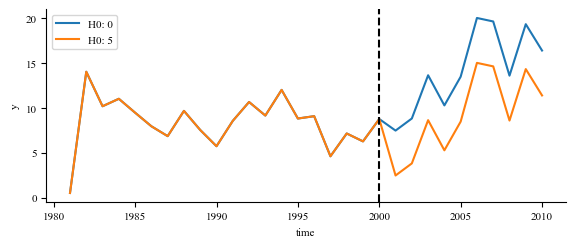

In [306]:
# under the null = 0
null_0 = under_null(df, 0, 'treated')
# under the null = 5
null_5 = under_null(df, 5, 'treated')

plt.figure(figsize=(6.7, 2.5))
# plot the generated data under different null hypothesis
sns.lineplot(null_0.query("tr_group==1").groupby('time').y.mean(), label='H0: 0')
sns.lineplot(null_5.query("tr_group==1").groupby('time').y.mean(), label='H0: 5')

plt.axvline(x=df.query("post_period==0").time.max(), linestyle='--', color='black')
sns.despine()

### 3. Fit the model use the control dataset

In [307]:
# define a function to transform matrix
def _prepare_matrix(df, covariates):
    Y = df.pivot(index='id', columns='time', values='y').values
    X = np.array([df.pivot(index='id', columns='time', values=x) for x in covariates]).transpose(1, 2, 0)
    return Y, X

In [308]:
# add constant
null_5['const'] = 1
# gen covariates
covariates = ['const'] + [f'x{i+1}' for i in range(L)]

# use the control data to compute F and Gama
Y, X = _prepare_matrix(null_5.query("tr_group==0"), covariates)

In [309]:
# define a function to conduct ALS estimation
def als_est(X, Y, K, F0):
    N, T, L = X.shape
    # with F fixed, estimate Gama
    vec_len = L*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T):
        for i in range(N):
            # slice X and F
            X_slice = X[i, t, :]
            F_slice = F0[:, t]
            # compute kronecker product
            kron_prod = np.kron(X_slice, F_slice)
            # update numer and denom
            numer += kron_prod * Y[i, t]
            denom += np.outer(kron_prod, kron_prod)
    # solve for Gama
    Gama1 = _mldivide(denom, numer).reshape(L, K)

    # with Gama fixed, estimate F
    F1 = np.zeros((K, T))
    for t in range(T):
        denom = Gama1.T@X[:,t,:].T@X[:,t,:]@Gama1
        numer = Gama1.T@X[:,t,:].T@Y[:,t]
        F1[:, t] = _mldivide(denom, numer)
    return Gama1, F1

In [310]:
# define a function to compute F and Gama
def update_parameter(Y, X, K, MaxIter=100, MinTol=1e-6, verbose=True):
    N, T, L = X.shape
    # step 1: initial guess
    svU, svS, svV = ssla.svds(Y, K)
    svU, svS, svV = np.fliplr(svU), svS[::-1], np.flipud(svV)
    
    # initial guess for F
    F0 = np.diag(svS) @ svV
    # initial guess for Gama
    Gama0 = np.zeros((L, K))

    # iteratively update F and Gama
    tol, iter = float('inf'), 0
    while tol > MinTol and iter < MaxIter:
        Gama1, F1 = als_est(X, Y, K, F0)
        tol_Gama = abs(Gama1 - Gama0).max()
        tol_F = abs(F1 - F0).max() 
        tol = max(tol_Gama, tol_F)
        if verbose:
            print(f'iter: {iter}, tol_Gama: {tol_Gama}, tol_F: {tol_F}')
        F0, Gama0 = F1, Gama1
        iter += 1
    return F1, Gama1

In [311]:
# compute F and Gama with 
F1, Gama1 = update_parameter(Y, X, K, verbose=True)

iter: 0, tol_Gama: 0.08549601254358268, tol_F: 33.773441484225486
iter: 1, tol_Gama: 0.005790613498807981, tol_F: 40.02835686491073
iter: 2, tol_Gama: 0.003382616401786033, tol_F: 12.745151513875065
iter: 3, tol_Gama: 0.002003749239587453, tol_F: 9.969330788060454
iter: 4, tol_Gama: 0.0012732749587063275, tol_F: 14.376131533354126
iter: 5, tol_Gama: 0.0013857428672072875, tol_F: 18.264193287080253
iter: 6, tol_Gama: 0.0017780174403643628, tol_F: 24.647071978847276
iter: 7, tol_Gama: 0.0023488309114026856, tol_F: 26.20886633849158
iter: 8, tol_Gama: 0.002028747963908853, tol_F: 13.585417333316094
iter: 9, tol_Gama: 0.0009394621504500433, tol_F: 4.090973875713324
iter: 10, tol_Gama: 0.0003523495656224396, tol_F: 1.3064539671047015
iter: 11, tol_Gama: 0.00014649518364247271, tol_F: 0.5336815175403871
iter: 12, tol_Gama: 7.104509482033783e-05, tol_F: 0.2922909474964328
iter: 13, tol_Gama: 3.8788764175720636e-05, tol_F: 0.1878641731118229
iter: 14, tol_Gama: 2.280303366800074e-05, tol_F: 0.

### 4. Predict the treated units for whole time period (Main difference with estimation)

In [312]:
# gen Y, X for treated units all period
Y1, X1 = _prepare_matrix(null_5.query("tr_group==1"), covariates)

In [313]:
# define a function to compute Gama for treated units
def estimate_gama(Y, X, F1):
    N, T, L = X.shape
    # with F fixed, estimate Gama
    vec_len = L*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T):
        for i in range(N):
            X_slice = X[i, t, :]
            F_slice = F1[:, t]
            kron_prod = np.kron(X_slice, F_slice)
            # update numer and denom
            numer += kron_prod * Y[i, t]
            denom += np.outer(kron_prod, kron_prod)
    # solve for Gama
    Gama1 = _mldivide(denom, numer).reshape(L, K)
    return Gama1

In [314]:
Gama_tr = estimate_gama(Y1, X1, F1)
Gama_tr

array([[-0.01179235,  0.13736124],
       [-0.00442678,  0.01730267],
       [-0.00882583,  0.05835352],
       [-0.01175996,  0.04050768],
       [-0.01394936,  0.0517624 ],
       [-0.00687298,  0.05926226],
       [-0.02095129,  0.05080155],
       [-0.00194423,  0.03008847],
       [-0.01420499,  0.06677223],
       [ 0.00230741,  0.01440588],
       [-0.00763962,  0.0338708 ]])

In [315]:
# predict Y1_hat for the whole period
N, T, L = X1.shape
Y1_hat = np.zeros((N, T))
for t in range (T):
    for i in range(N):
        Y1_hat[i, t] = X1[i, t, :] @ Gama_tr @ F1[:, t]

In [316]:
resid = null_5.query("tr_group==1").groupby("time").y.mean().to_frame()
resid['y1_hat'] = Y1_hat.mean(axis=0)
resid['residual'] = resid.y - resid['y1_hat']
resid['post_period'] = null_5.groupby('time').post_period.min()

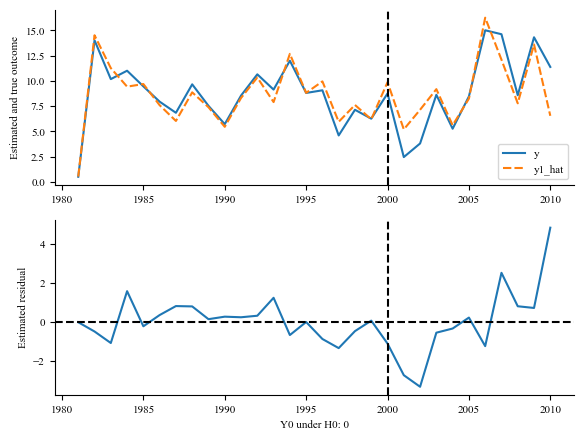

In [317]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))
sns.lineplot(resid[['y', 'y1_hat']], ax=ax[0])

sns.lineplot(resid['residual'], ax=ax[1])
ax[1].axhline(y=0, linestyle='--', color='black')
ax[0].set(ylabel='Estimated and true outcome', xlabel='')
ax[1].set(ylabel='Estimated residual', xlabel='Y0 under H0: 0')

for i in range(2):
    ax[i].axvline(x=resid.query("post_period==0").index[-1], linestyle='--', color='black')
sns.despine()

In [318]:
# define a function to combine all the above steps
def compute_residual(df, K, verbose=True):
    # prepare matrix with all data
    Y, X = _prepare_matrix(df.query("tr_group==0"), covariates)
    F1, Gama1 = update_parameter(Y, X, K, verbose=verbose)
    # prepare matrix with treated data
    Y1, X1 = _prepare_matrix(df.query("tr_group==1"), covariates)
    # update Gama for treated units
    Gama_tr = estimate_gama(Y1, X1, F1)

    # predict Y1_hat for the whole period
    N, T, L = X1.shape
    Y1_hat = np.zeros((N, T))
    for i in range(N):
        for t in range(T):
            Y1_hat[i, t] = X1[i, t, :] @ Gama_tr @ F1[:, t]
    
    # compute residual
    resid = df.query("tr_group==1").groupby("time").y.mean().to_frame()
    resid['y1_hat'] = Y1_hat.mean(axis=0)
    resid['residual'] = resid.y - resid['y1_hat']
    resid['post_period'] = df.groupby('time').post_period.min()
    return resid

In [319]:
# compute residual under H0: 0
x = compute_residual(null_5, K, verbose=False)
# check if it is the same as the previous result
np.allclose(x['residual'], resid['residual'])

True

### 5. Test statistic


$$
S(\hat{u}) = S_q(\hat{u}) = \left( \frac{1}{\sqrt{T_*}} \sum_{t=T_0+1}^{T} |\hat{u}_t|^q \right)^{1/q}.
$$
+ Note that S is constructed such that high values indicate rejection. 

+ If the intervention has a large but only temporary effect, choose $ q= \infty $. 

+ If the inter- vention has a permanent effect, tests using S1 or S2 exhibit good power properties.

In [320]:
# define a function to compute test statistic
def test_statistic(u_hat, q=1, axis=0):
    return (np.abs(u_hat) ** q).mean(axis=axis) ** (1/q)

In [321]:
print("H0:0 ", test_statistic(resid.query("post_period==1")["residual"]))

H0:0  1.7296124393682326


### 6. P value

`P-values`

+ We use block permutations to compute p-values. There are two approches:

1. The set of all permutations, which we call iid permutations, $\Pi_{all}$

2. The set of all (overlapping) moving block permutations, $\Pi_{\rightarrow}$

+ The choice of $\Pi$ does not matter for the exact finite sample validity of our procedures if the residuals are exchangeable.

Definition of p-value

\begin{equation*}
\hat{p} = 1 - \hat{F}(S(\hat{u})), \text{ where } \hat{F}(x) = \frac{1}{|\Pi|} \sum_{\pi \in \Pi} 1\{S(\hat{u}_\pi) < x\}.
\end{equation*}

In [322]:
u = resid["residual"].values
    
block_permutations = np.stack([np.roll(u, permutation, axis=0)[resid.post_period==1]
                                   for permutation in range(len(u))])
statistics = test_statistic(block_permutations, q=1, axis=1)

p_val = np.mean(statistics >= statistics[0])
print("Under the null H0:0, the p value is", p_val)

Under the null H0:0, the p value is 0.03333333333333333


In [300]:
# add a const to the original data
df['const'] = 1

# grid search the p value under difference null hypothesis
nulls = np.linspace(-50, 50, 100)
p_vals = {}
for null in nulls:
    # build the data under the null
    null_df = under_null(df, null, 'treated')
    # compute residual
    resid = compute_residual(null_df, K=2, verbose=False )
    u = resid['residual'].values

    # block permutation
    block_permutations = np.stack([np.roll(u, permutation, axis=0)[resid.post_period==1] for permutation in range(len(u))])
    # compute test statistic
    stat = test_statistic(block_permutations, q=1, axis=1)
    # compute p value
    p_val = np.mean(stat >= stat[0])

    # store the result
    p_vals[null] = p_val

In [301]:
p_vals = pd.DataFrame(p_vals, index=['all']).T
p_vals

,all
-50.000000,0.033333
-48.989899,0.033333
-47.979798,0.033333
-46.969697,0.033333
-45.959596,0.033333
...,...
45.959596,0.033333
46.969697,0.033333
47.979798,0.033333
48.989899,0.033333


### 7. Confidence interval

In [323]:
# define a function to compute confidence interval
def confidence_interval(p_vals, alpha=0.1):
    big_p_vals = p_vals[p_vals.values >= alpha]
    return pd.DataFrame({
        f"{int(100-alpha*100)}_ci_lower": big_p_vals.index.min(),
        f"{int(100-alpha*100)}_ci_upper": big_p_vals.index.max()
    }, index=[p_vals.columns[0]])

In [324]:
confidence_interval(p_vals, 0.1)

,90_ci_lower,90_ci_upper
all,-7.575758,16.666667


### 8. Compute confidence interval for each period

In [325]:
def period_pval(df, period, nulls):
    # only choose the target period and pre intervention period
    df_aug = df[(df.post_period==0) | (df.time==period)]

    p_vals = {}
    for null in nulls:
        # buidl the data under the null
        null_df = under_null(df_aug, null, 'treated')
        # compute the residual
        resid = compute_residual(null_df, K=2, verbose=False)
        u = resid['residual'].values

        # block permutation
        block_permutations = np.stack([np.roll(u, permutation, axis=0)[resid.post_period==1] for permutation in range(len(u))])
        # compute test statistic
        stat = test_statistic(block_permutations, q=1, axis=1)
        # compute p value
        p_val = np.mean(stat >= stat[0])
        p_vals[null] = p_val
    return pd.DataFrame(p_vals, index=[period]).T

In [326]:
start_tr = df.query("post_period==1").time.min()
end_tr = df.query("post_period==1").time.max()

In [328]:
df['const'] = 1
ci_df = pd.DataFrame()
nulls = np.linspace(-10, 50, 100)
for t in range(start_tr, end_tr+1):
    p_vals = period_pval(df, t, nulls)
    ci = confidence_interval(p_vals, 0.1)
    ci_df = pd.concat([ci_df, ci], axis=0)
    print(t)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


In [329]:
from src.csc_ipca import gsc_ipca
# issue the model
model = gsc_ipca()
# use control data to fit the model
df_con = df.query("tr_group==0")
model.fit(df_con, 'id', 'time', 'y', covariates, 2, verbose=False)
# predict treated data
df_tr = df.query("tr_group==1")
Y_synth = model.predict(df_tr, 'id', 'time', 'y', covariates, 2, 'treated')

In [330]:
residual = df.query("tr_group==1").groupby('time').y.mean() - Y_synth.mean(axis=0)
ci_df['est_att'] = residual[-T1:]
ci_df

,90_ci_lower,90_ci_upper,est_att
2001,-0.303030,2.121212,0.949757
2002,0.303030,2.727273,1.575376
2003,3.333333,5.757576,4.464113
2004,3.333333,5.757576,4.659729
2005,2.727273,5.757576,4.465837
2006,2.727273,5.151515,3.818479
2007,6.363636,8.787879,7.500285
2008,5.151515,6.969697,5.957568
2009,4.545455,8.787879,7.077516
2010,9.393939,11.818182,10.901581


<ErrorbarContainer object of 3 artists>

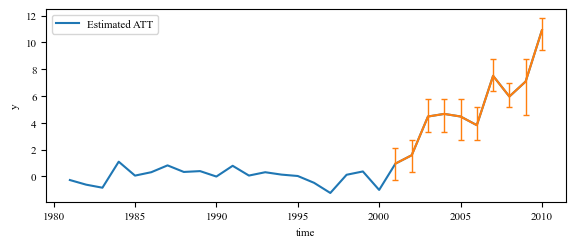

In [334]:
plt.figure(figsize=(6.7, 2.5))

sns.lineplot(residual, label='Estimated ATT')

yerr = np.abs(ci_df[['90_ci_lower', '90_ci_upper']].subtract(ci_df['est_att'], axis=0)).T.values
# Plot error bars for the last T1 periods
plt.errorbar(x=residual.index[-T1:], y=residual[-T1:], yerr=yerr[:, -T1:], capsize=2, capthick=1, elinewidth=1)


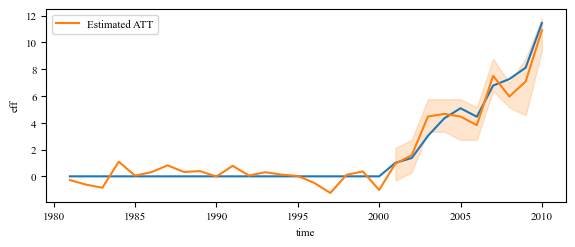

In [339]:
plt.figure(figsize=(6.7, 2.5))

sns.lineplot(df.query("tr_group==1").groupby("time").eff.mean())
sns.lineplot(residual, label='Estimated ATT')

yerr = np.abs(ci_df[['90_ci_lower', '90_ci_upper']].subtract(ci_df['est_att'], axis=0)).T.values

plt.fill_between(ci_df.index, ci_df["90_ci_lower"], ci_df["90_ci_upper"], alpha=0.2,  color="C1")
